In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.signal import butter, filtfilt
from scipy.signal import savgol_filter
from scipy.integrate import simpson
import os


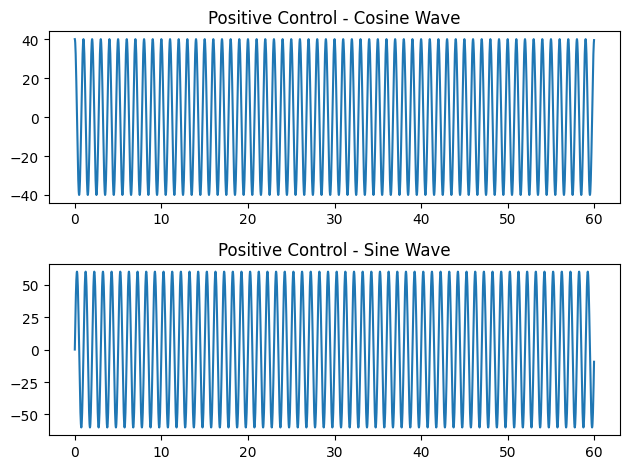

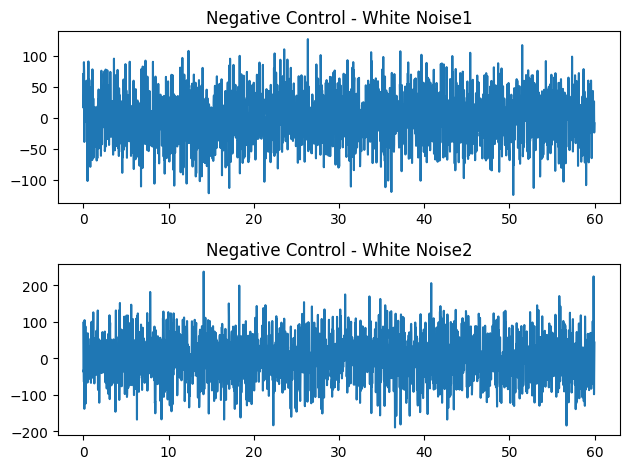

In [3]:

# Constants
sampling_rate = 40  # Hz
duration = 60  # seconds
t = np.linspace(0, duration, duration * sampling_rate, endpoint=False)  # Time vector

# DataFrames for sine and cosine
cos_signal = pd.DataFrame({
    'time': t,
    'signal': (np.cos(2 * np.pi * t))*40
})

sin_signal = pd.DataFrame({
    'time': t,
    'signal': (np.sin(2 * np.pi * t))* 60
})

# DataFrames for white noise
np.random.seed(0)  # For reproducibility
white_noise1 = pd.DataFrame({
    'time': t,
    'signal': (np.random.normal(0, 1, size=t.shape[0]))*40
})

np.random.seed(1)  # Different seed for a different noise pattern
white_noise2 = pd.DataFrame({
    'time': t,
    'signal': (np.random.normal(0, 1, size=t.shape[0]))*60
})
plt.subplot(2, 1, 1)
plt.plot(cos_signal['time'], cos_signal['signal'])
plt.title('Positive Control - Cosine Wave')
plt.subplot(2, 1, 2)
plt.plot(sin_signal['time'], sin_signal['signal'])
plt.title('Positive Control - Sine Wave')
plt.tight_layout()
plt.show()

plt.subplot(2, 1, 1)
plt.plot(white_noise1['time'], white_noise1['signal'])
plt.title('Negative Control - White Noise1')
plt.subplot(2, 1, 2)
plt.plot(white_noise2['time'], white_noise2['signal'])
plt.title('Negative Control - White Noise2')
plt.tight_layout()
plt.show()

In [47]:


# Set target sampling rate
target_fs = 40  # Hz

def compute_peak_sharpness(lag_times, corr, window=2.0):
    """Compute AUC around lag 0 and normalize it by total AUC."""
    corr = np.array(corr)
    lag_times = np.array(lag_times)

    # Indices within the desired window around lag 0
    central_mask = np.abs(lag_times) <= window

    # AUC using Simpson's rule for both central and total
    auc_central = simpson(np.abs(corr[central_mask]), lag_times[central_mask])
    auc_total = simpson(np.abs(corr), lag_times)

    normalized_auc = auc_central / auc_total if auc_total != 0 else np.nan

    # print(f"AUC around lag 0 (±{window} sec): {auc_central:.2f}")
    # print(f"Total AUC: {auc_total:.2f}")
    # print(f"Normalized Central AUC: {normalized_auc:.4f}")

    return auc_central, auc_total, normalized_auc

# Example usage inside your loop:
# compute_peak_sharpness(lag_times, corr, window=2.0)

# Function to smooth and plot signals
def smooth_and_plot_signal(time, signal, signal_type, window_length=101, polyorder=3,
                           title="Smoothed Signal", xlabel="Time (s)", ylabel="Signal", show=True):
    # Ensure window_length is odd and not larger than the signal length.
    if window_length % 2 == 0:
        window_length += 1
    if window_length > len(signal):
        window_length = len(signal) - (1 - len(signal) % 2)

    smoothed = savgol_filter(signal, window_length, polyorder)

    plt.figure(figsize=(12, 4))
    if signal_type == 'lfp':
        plt.plot(time, signal, alpha=0.6, label="Raw Signal", color='darkred')
        # plt.ylim(-70, 70)
        plt.ylim(-120, 120)
        plt.plot(time, smoothed, linewidth=2, label="Smoothed Signal", color='gray')
    elif signal_type == 'o2':
        plt.plot(time, signal, alpha=0.6, label="Raw Signal")
        plt.ylim(10, 80)
        plt.ylim(-120, 120)
        plt.plot(time, smoothed, linewidth=2, label="Smoothed Signal", color='gray')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    if show:
        plt.show()

    return smoothed

# Function to detect events
def detect_events(signal, threshold_pos, threshold_neg, window_width=1):
    if window_width % 2 == 0:
        window_width += 1
    half_window = window_width // 2

    events = np.zeros_like(signal)
    above = signal > threshold_pos
    below = signal < threshold_neg
    i = 0
    while i < len(signal):
        if above[i]:
            start = i
            while i < len(signal) and above[i]:
                i += 1
            end = i
            segment = signal[start:end]
            idx_max = np.argmax(segment) + start
            start_window = max(0, idx_max - half_window)
            end_window = min(len(signal), idx_max + half_window + 1)
            events[start_window:end_window] = 1
        else:
            i += 1
        if i >= len(signal):
            break
        if below[i]:
            start = i
            while i < len(signal) and below[i]:
                i += 1
            end = i
            segment = signal[start:end]
            idx_min = np.argmin(segment) + start
            start_window = max(0, idx_min - half_window)
            end_window = min(len(signal), idx_min + half_window + 1)
            events[start_window:end_window] = -1

    return events

# Function to compute cross correlation
def compute_cross_correlation(sig1, sig2, fs):
    n = len(sig1)
    corr = np.correlate(sig1, sig2, mode='full')
    lags = np.arange(-n + 1, n)
    lag_times = lags / fs
    return lag_times, corr

def process_signals(lfp_dfs, o2_dfs, treatment_names, cond_th, yax_range=2500):
    colors = ['darkgreen','darkorange', 'purple' ]
    # Compute baseline standard deviation and set thresholds
    baseline_indx = treatment_names.index(cond_th)
    lfp_sd = np.std(lfp_dfs[baseline_indx]['signal'])
    o2_sd = np.std(o2_dfs[baseline_indx]['signal'])
    threshold_lfp = lfp_sd*1
    threshold_o2 = o2_sd*1
    plt.figure(figsize=(12, 4))
    cc_list = []
    lags_list = []
    dfs_dict = {}
    for i, (lfp_df, o2_df) in enumerate(zip(lfp_dfs, o2_dfs)):
        # reset time to start at  0
        lfp_df['time'] = lfp_df['time'].values - lfp_df['time'].values[0]
        o2_df['time'] = o2_df['time'].values - o2_df['time'].values[0]
        # Creating a common time vector
        common_duration = min(lfp_df['time'].iloc[-1], o2_df['time'].iloc[-1])
        new_time = np.arange(0, common_duration, 1/target_fs)

        # Resampling signals by interpolation
        lfp_interp = np.interp(new_time, lfp_df['time'], lfp_df['signal'])
        o2_interp = np.interp(new_time, o2_df['time'], o2_df['signal'])

        # Smoothing the signals
        lfp_smoothed = smooth_and_plot_signal(new_time, lfp_interp, 'lfp', window_length=21, polyorder=4,
                                              title=f"Smoothed LFP Signal ({treatment_names[i]})")
        o2_smoothed = smooth_and_plot_signal(new_time, o2_interp, 'o2', window_length=21, polyorder=4,
                                             title=f"Smoothed O₂ Signal ({treatment_names[i]})")

        # Zero-mean adjustment
        lfp_zero = lfp_smoothed - np.mean(lfp_smoothed)
        o2_zero = o2_smoothed - np.mean(o2_smoothed)


        # Event detection
        # lfp_events = detect_events(lfp_zero, threshold_lfp, ((-1)*threshold_lfp), window_width=9)
        lfp_events = detect_events(lfp_zero, threshold_lfp, ((-1)*threshold_lfp), window_width=19)
        o2_events = detect_events(o2_zero, threshold_o2, ((-1)*threshold_o2), window_width=19)
        # o2_events = detect_events(o2_zero, threshold_o2, ((-1)*threshold_o2), window_width=9)

        # Plot detected events
        plt.figure(figsize=(12, 4))
        plt.plot(new_time, lfp_events, label="LFP Events", color='darkred')
        plt.plot(new_time, o2_events, label="O₂ Events")
        plt.title(f"{treatment_names[i]} Detected Events")
        plt.xlabel("Time (s)")
        plt.legend()
        plt.show()

        # Compute cross-correlation
        lag_times, corr = compute_cross_correlation(lfp_events, o2_events, fs=target_fs)
        plt.figure(figsize=(10, 4))
        plt.plot(lag_times, corr, color=colors[i], label = treatment_names[i])
        plt.title(f"{treatment_names[i]} Cross Correlation")
        plt.xlabel("Lag (s)")
        plt.ylabel("Correlation")
        plt.ylim(-300,300)
        plt.ylim(-yax_range,yax_range)
        # plt.ylim(-70,70)
        plt.axvline(0, color='k', linestyle='--')
        plt.show()
        # print highest coerelation idx
        corr , lag_times = list(corr), list(lag_times)
        pos_cor_max_indx = corr.index(max(corr))
        neg_cor_max_indx = corr.index(min(corr))
        pos_cor_max = lag_times[pos_cor_max_indx]
        neg_cor_max = lag_times[neg_cor_max_indx]
        print(f"{treatment_names[i]}")
        print(f"Maximum positive correlation: {max(corr)}" )
        print(f"Maximum negative correlation: {min(corr)}" )
        print(f"Maximum positive correlation lag: {pos_cor_max} seconds")
        print(f"Maximum negative correlation lag: {neg_cor_max} seconds")
        auc_central, auc_total, normalized_auc = compute_peak_sharpness(lag_times, corr, window=2.0)
        print(f"AUC around lag 0 (±2 sec): {auc_central:.2f}")
        print(f"Total AUC: {auc_total:.2f}")
        print(f"Normalized Central AUC: {normalized_auc:.4f}")
        cc_df = pd.DataFrame({'lag': lag_times, 'corr': corr})
        dfs_dict[treatment_names[i]] = cc_df



    return dfs_dict




<Figure size 1200x400 with 0 Axes>

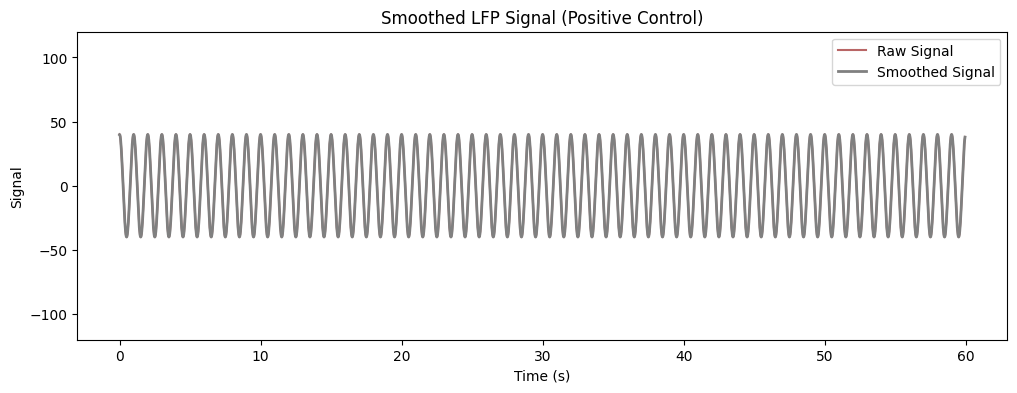

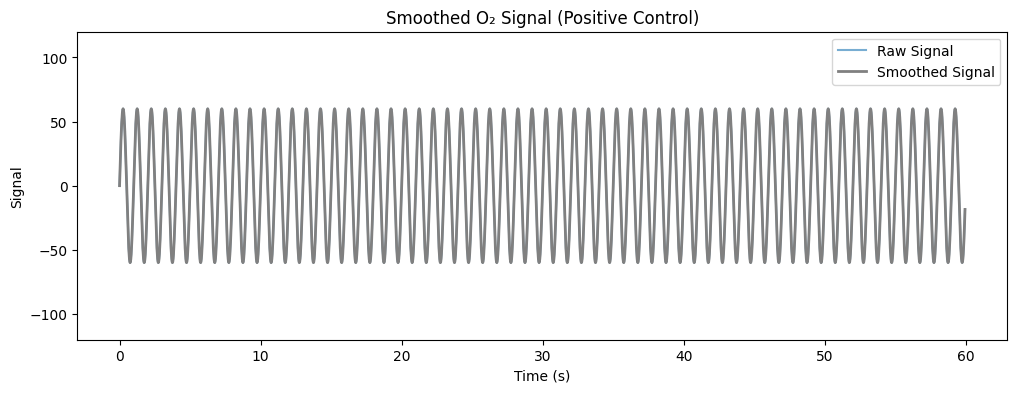

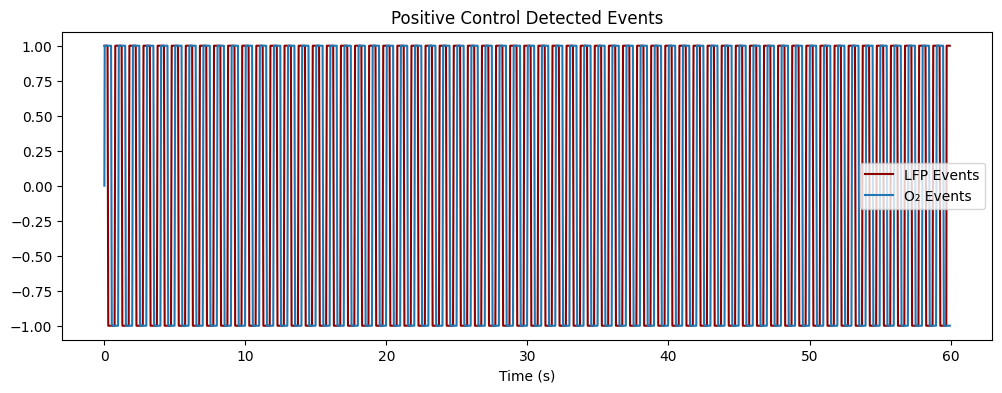

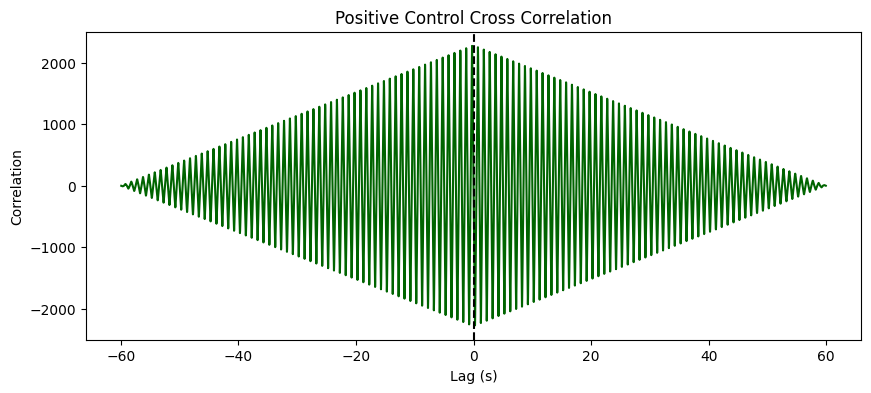

Positive Control
Maximum positive correlation: 2270.0
Maximum negative correlation: -2267.0
Maximum positive correlation lag: -0.25 seconds
Maximum negative correlation lag: 0.25 seconds
AUC around lag 0 (±2 sec): 4701.41
Total AUC: 71694.11
Normalized Central AUC: 0.0656


<Figure size 1200x400 with 0 Axes>

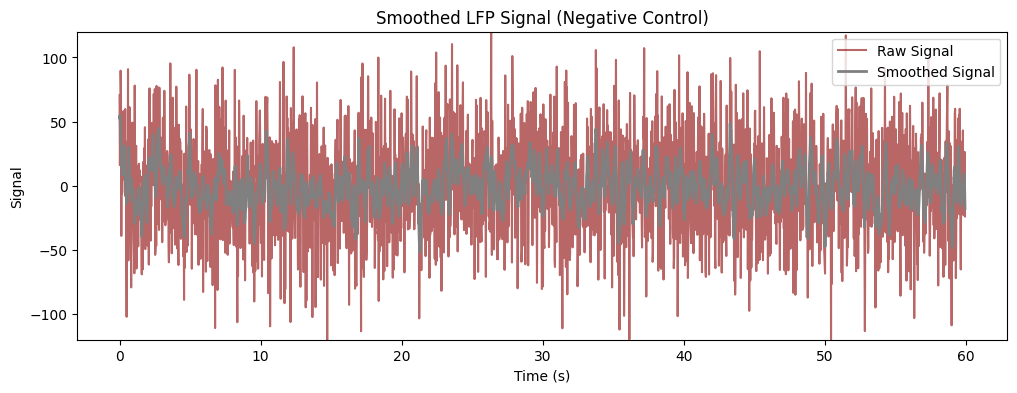

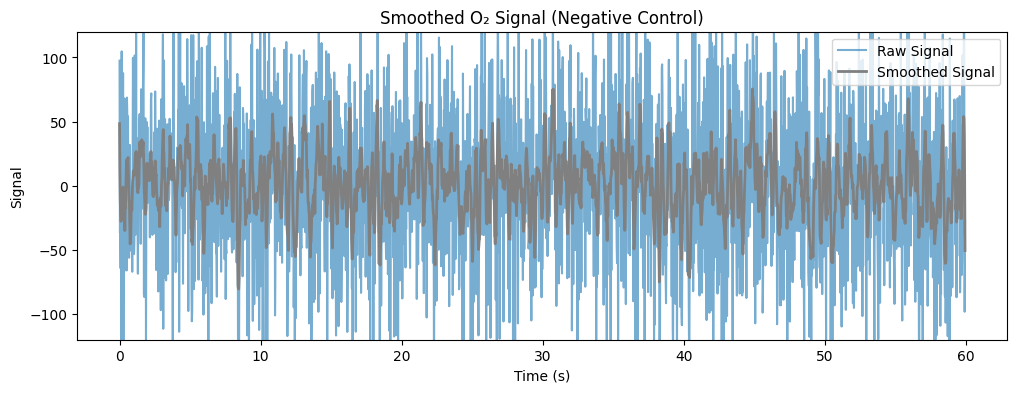

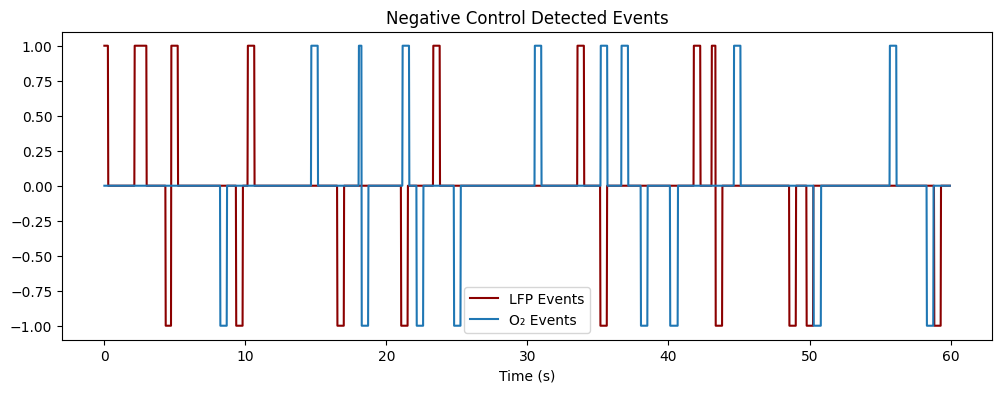

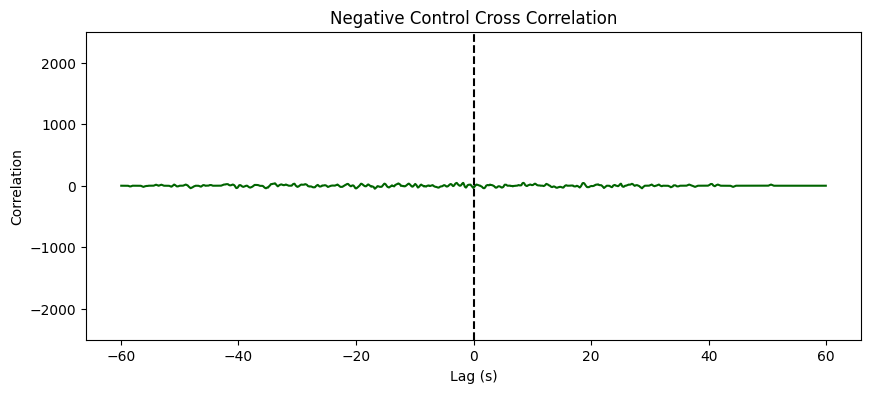

Negative Control
Maximum positive correlation: 46.0
Maximum negative correlation: -48.0
Maximum positive correlation lag: -2.875 seconds
Maximum negative correlation lag: -16.8 seconds
AUC around lag 0 (±2 sec): 74.61
Total AUC: 1193.72
Normalized Central AUC: 0.0625


In [23]:
# Example usage: Control signals



# lfp_blc_b17, o2_blc_b17, lfp_blc_met_b17, o2_blc_met_b17
treatment_names = ['Positive Control', 'sin_signal']

cond_th = 'Positive Control'
dfs_dict = process_signals([cos_signal], [sin_signal], treatment_names, cond_th)

treatment_names = ['Negative Control', 'White Noise2']

cond_th = 'Negative Control'
dfs_dict = process_signals([white_noise1], [white_noise2], treatment_names, cond_th)


Cross Correlation eaxample for real LFP and O2 data from TTX treated organoid

In [30]:
# change to your working directory
os.chdir(r'C:\Users\klilasulin\Dropbox\brain on a chip\Human brain organoids article\EMChip_paper_analysis_git')
os.getcwd()
#


'C:\\Users\\klilasulin\\Dropbox\\brain on a chip\\Human brain organoids article\\EMChip_paper_analysis_git'

In [58]:
sampling_rate = 200 # Hz
# load example data
exp_dict = {'LFP_baseline': {'start_sec': 42 , 'stop_sec': 102, 'file_path': 'data/Raw_LFP_signals_example/baseline1_OpenBCI-RAW-2025-01-05_17-16-53.txt'},
            'LFP_TTX':{'start_sec': 40 , 'stop_sec': 100, 'file_path': 'data/Raw_LFP_signals_example/ttx2_OpenBCI-RAW-2025-01-05_18-14-31.txt'} ,
            'O2_baseline': {'start_sec': 42 , 'stop_sec': 102, 'file_path': 'data/Raw_O2_signals_example/baseline1.txt'},
            'O2_TTX': {'start_sec': 40 , 'stop_sec': 100, 'file_path': 'data/Raw_O2_signals_example/ttx2.txt'}}

In [59]:

def create_lfp_df(file_name: str, sampling_rate: int, chan: str, start_sec: int, stop_sec: int) -> pd.DataFrame:
    """
    Reads a CSV file, keeps only 'time' and the specified 'chan' columns,
    and splits the result into 5-minute chunks based on the time column.

    :param file_name: Path to the CSV file.
    :param sampling_rate: Number of samples per second (used only to create the 'time' column
                          if the file does not already contain one).
    :param chan: The channel/column to keep in addition to 'time'.
    :return: A list of DataFrames, each corresponding to a 5-minute segment (300 seconds).
    """

    # Read the CSV file
    df = pd.read_csv(
        file_name,
        header=4,      # adjust if needed
        sep=', ',
        on_bad_lines='skip',
        engine='python'
    )

    # Create 'time' column using DataFrame index / sampling_rate (if needed)
    # If your CSV already has a 'time' column in seconds, you could skip this step
    row_indexes = np.array(df.index.tolist())
    df['time'] = row_indexes / sampling_rate

    # Keep only 'time' and the specified channel
    df = df[['time', chan]]

    df = df[(df['time'] >= start_sec) & (df['time'] <= stop_sec)]
    df['time'] = df['time'].values - start_sec
    df.rename(columns={chan: 'data'}, inplace=True)



   

    return df





def create_o2_df(file_path: str, start_sec: int, stop_sec: int) -> pd.DataFrame:
    """
    Reads an O2 data file and returns a DataFrame with 'time' and 'o2' columns.
    Skips the first 6 metadata lines.
    Assumes each subsequent line has two tab-separated columns: time_in_seconds and o2_value.
    """
    time_data = []
    o2_data = []

    with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
        lines = f.readlines()

    # Skip metadata lines (the snippet shows ignoring the first 6 lines)
    for i in range(6, len(lines)):
        fields = lines[i].strip().split('\t')
        if len(fields) < 2:
            continue
        try:
            t = float(fields[0])
            o2_val = float(fields[1])
            time_data.append(t)
            o2_data.append(o2_val)
        except ValueError:
            continue

    df = pd.DataFrame({'time': time_data, 'data': o2_data})
    df = df[(df['time'] >= start_sec) & (df['time'] <= stop_sec)]
    df['time'] = df['time'].values - start_sec


    return df


In [60]:
for exp_name, params in exp_dict.items():
    if 'LFP' in exp_name:
        file_path = params['file_path']
        lfp_df = create_lfp_df(file_path, sampling_rate, 'EXG Channel 0', params['start_sec'], params['stop_sec'])
        # rename data column to 'signal'
        lfp_df.rename(columns={'data': 'signal'}, inplace=True)
        # add lfp_dfs to exp_dict
    
        exp_dict[exp_name]['data_df'] = lfp_df
        
        
    elif 'O2' in exp_name:
        file_path = params['file_path']
        o2_df = create_o2_df(file_path, params['start_sec'], params['stop_sec'])
        # rename data column to 'signal'
        o2_df.rename(columns={'data': 'signal'}, inplace=True)
        # add o2_dfs to exp_dict
        exp_dict[exp_name]['data_df'] = o2_df



<Figure size 1200x400 with 0 Axes>

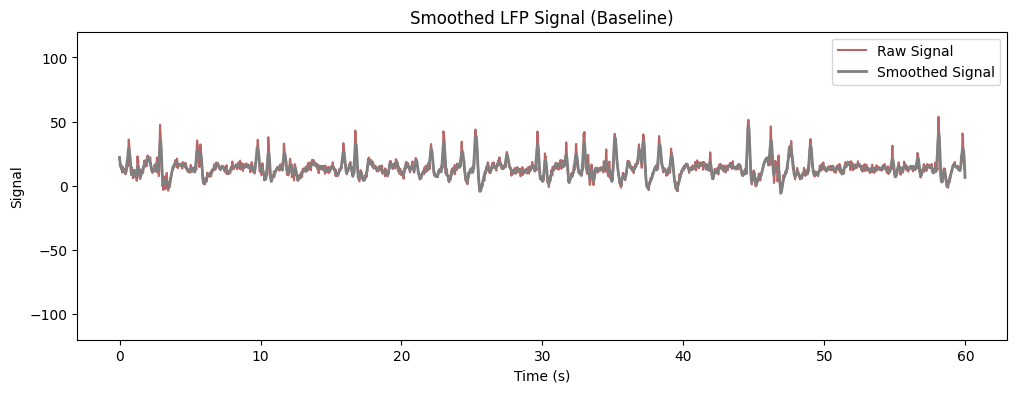

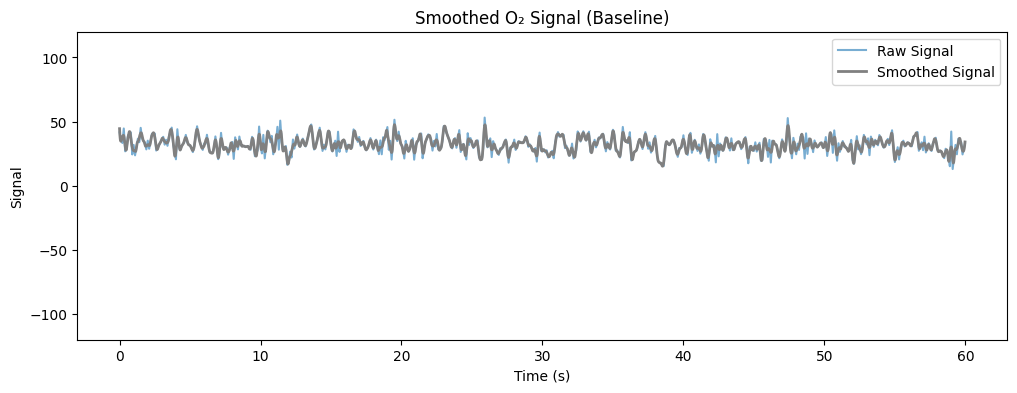

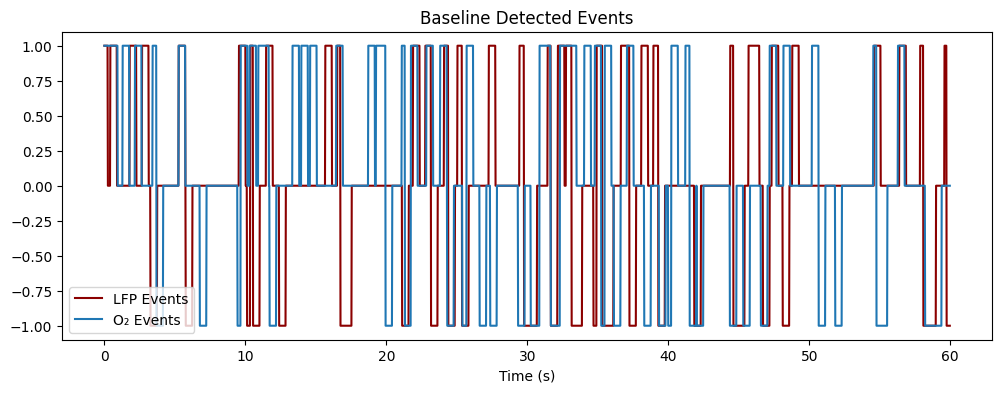

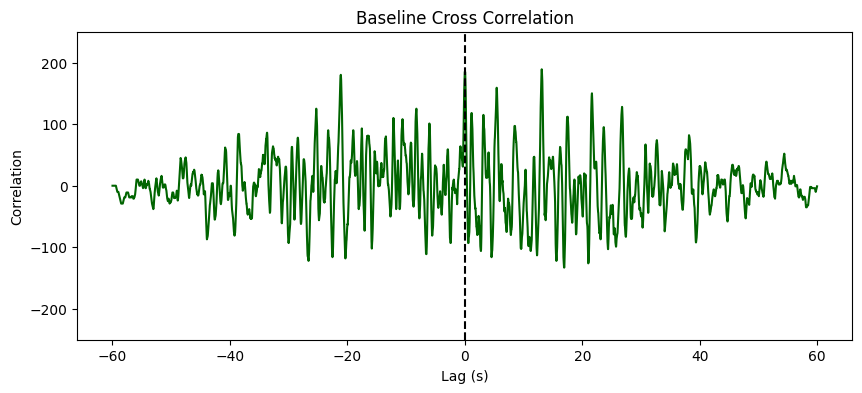

Baseline
Maximum positive correlation: 189.0
Maximum negative correlation: -133.0
Maximum positive correlation lag: 13.1 seconds
Maximum negative correlation lag: 16.925 seconds
AUC around lag 0 (±2 sec): 217.68
Total AUC: 4318.29
Normalized Central AUC: 0.0504


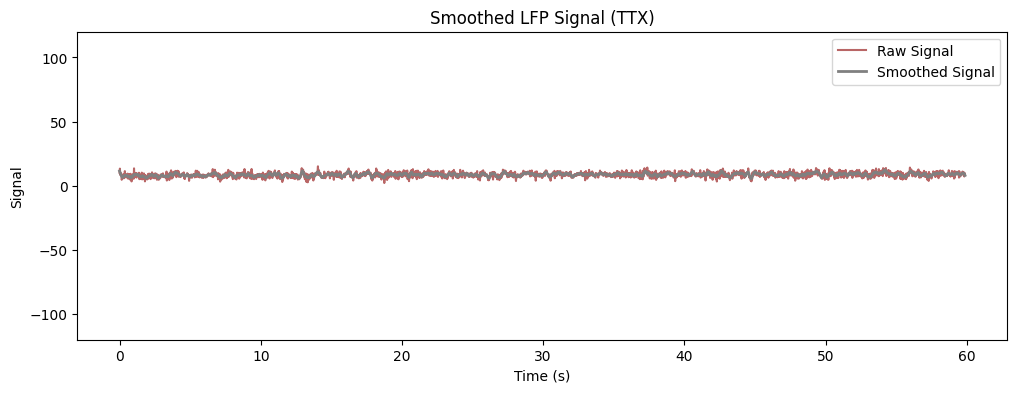

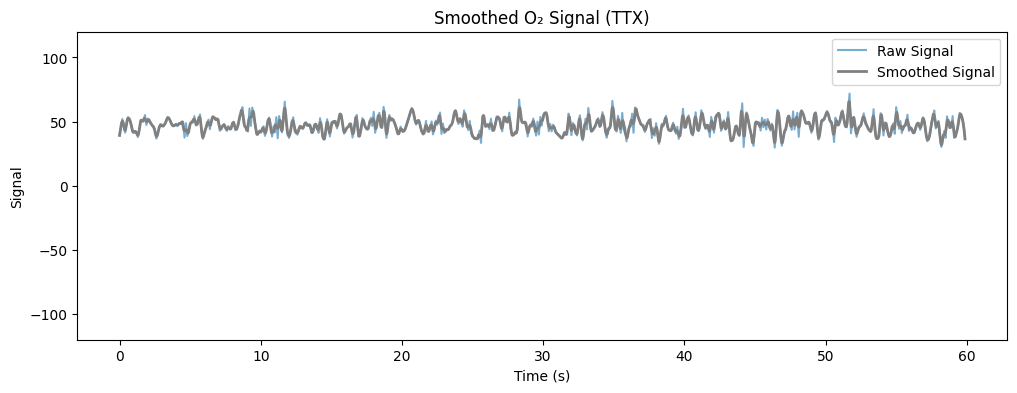

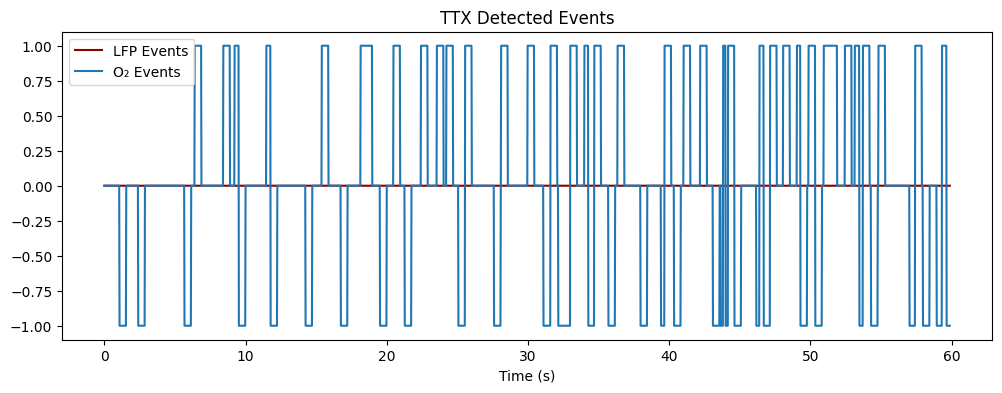

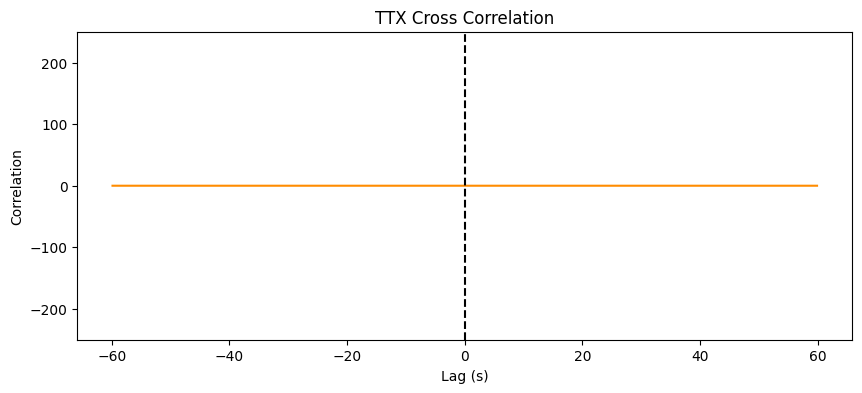

TTX
Maximum positive correlation: 0.0
Maximum negative correlation: 0.0
Maximum positive correlation lag: -59.875 seconds
Maximum negative correlation lag: -59.875 seconds
AUC around lag 0 (±2 sec): 0.00
Total AUC: 0.00
Normalized Central AUC: nan


In [62]:
# Example usage: LFP and O2



# lfp_blc_b17, o2_blc_b17, lfp_blc_met_b17, o2_blc_met_b17
treatment_names = ['Baseline', 'TTX']

cond_th = 'Baseline'
dfs_dict = process_signals([exp_dict['LFP_baseline']['data_df'], exp_dict['LFP_TTX']['data_df']], [exp_dict['O2_baseline']['data_df'], exp_dict['O2_TTX']['data_df']], treatment_names, cond_th, 250)

# treatment_names = ['Negative Control', 'White Noise2']

# cond_th = 'Negative Control'
# dfs_dict = process_signals([white_noise1], [white_noise2], treatment_names, cond_th)
